# Paralelización de un algoritmo genético para resolver el problema del viajante

Partiendo del Notebook [Using genetic algorithms to solve the traveling salesperson problem](https://github.com/lmarti/evolutionary-computation-course/blob/master/AEC.03%20-%20Solving%20the%20TSP%20with%20GAs.ipynb) del curso [Advanced Evolutionary Computation: Theory and Practice](https://github.com/lmarti/evolutionary-computation-course) de [Luis Martí](http://lmarti.com), explicamos el problema y ofrecemos dos propuestas de paralelización, con SCOOP y con MPI.


### Problema del viajante
> *Dado un conjunto de ciudades y distancias entre cada par de ciudades, encontrar un **recorrido** con la **mínima distancia total**.
Un **recorrido** comienza en una ciudad, visita todas las demás ciudades exactamente una vez y luego regresa a la ciudad inicial.*

##### Objetivos
- Se trata de un problema NP-Hard comúnmente conocido como intratable, lo que significa que no hay soluciones eficientes que funcionen para un gran número de ciudades.
- Podemos crear un algoritmo ineficiente que funcione bien para una pequeña cantidad de ciudades (aproximadamente una docena).
- También podemos encontrar un recorrido algo más corto para miles de ciudades.
- O aún mejor, podemos aprovecharnos de las ventajas de la computación distribuida.

##### Inicialización


In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import random, operator, time, itertools, math
import numpy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

/Users/giogiasvalley/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##### Recorridos entre ciudades
- Una representación natural del conjunto de ciudades disponibles es un `conjunto` de Python, y una representación natural de un recorrido es una secuencia que es una *permutación* del conjunto.
- La tupla `(1, 2, 3)`, por ejemplo, representa un recorrido que comienza en la ciudad 1, se mueve a 2, luego a 3 y luego regresa a 1 para finalizar el recorrido.

In [7]:
alltours = itertools.permutations # The permutation function is already defined in the itertools module
cities = {1, 2, 3}
list(alltours(cities))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

##### Distancia total de un recorrido

In [8]:
def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

##### Primer algoritmo: encontrar el recorrido con la distancia total más corta para todos los recorridos posibles

In [9]:
def exact_TSP(cities):
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(alltours(cities))

def shortest(tours): 
    "Return the tour with the minimum total distance."
    return min(tours, key=total_distance)

##### Distancia entre dos ciudades
Podemos construir la representación de una ciudad usando el mismo constructor que hace números complejos, habilitando el plano bidimensional (tiempo real; complejo). 

In [10]:
City = complex # Constructor for new cities, e.g. City(300, 400)

In [11]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return abs(A - B)

In [12]:
A = City(300, 0)
B = City(0, 400)
distance(A, B)

500.0

##### Generar ciudades

In [13]:
def generate_cities(n):
    "Make a set of n cities, each with random coordinates."
    return set(City(random.randrange(10, 890), 
                    random.randrange(10, 590)) 
               for c in range(n))

In [14]:
cities8, cities10, cities100, cities1000 = generate_cities(8), generate_cities(10), generate_cities(100), generate_cities(1000)
cities8

{(133+502j),
 (137+531j),
 (338+575j),
 (39+151j),
 (643+539j),
 (70+300j),
 (728+507j),
 (869+480j)}

##### Gráfica del recorrido

In [15]:
def plot_tour(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles, and the starting city as a red square.
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], style='gD', alpha=alpha, size=10)
    # plt.show()
    
def plotline(points, style='bo-', alpha=1, size=7, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    
    if color:
        plt.plot(X, Y, style, alpha=alpha, markersize=size, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha, markersize=size)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

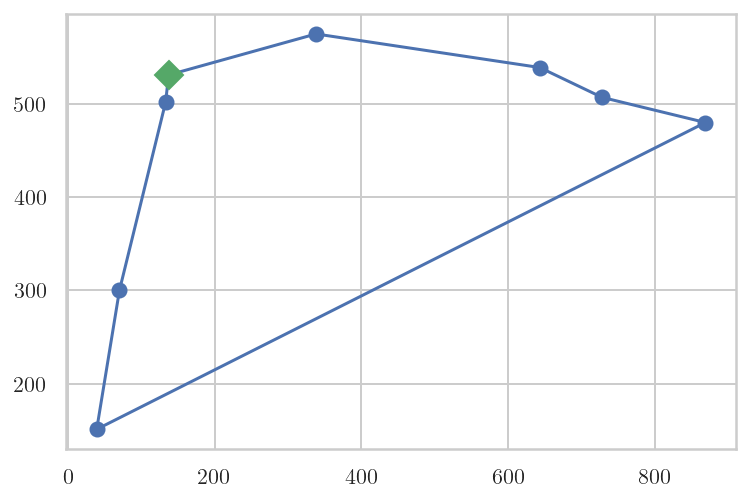

In [16]:
tour = exact_TSP(cities8) # probamos el algoritmo
plot_tour(tour) # pintamos el recorrido

##### Mejora del algoritmo con recorridos NO redundantes

In [17]:
def all_non_redundant_tours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + list(tour)
            for tour in itertools.permutations(cities - {start})]

def first(collection):
    "Start iterating over collection, and return the first element."
    for x in collection: return x

def exact_non_redundant_TSP(cities):
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(all_non_redundant_tours(cities))
all_non_redundant_tours({1, 2, 3})

[[1, 2, 3], [1, 3, 2]]

##### Tiempos de los algoritmos

In [18]:
%timeit exact_TSP(cities8)

163 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit exact_non_redundant_TSP(cities8)

23.1 ms ± 715 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Vemos que para el mismo set, la mejora con recorridos no redundantes es bastante mejor.

In [20]:
%timeit exact_non_redundant_TSP(cities10)

1.97 s ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Problema del viajante (Solución greedy)

In [21]:
def greedy_TSP(cities):
    "At each step, visit the nearest neighbor that is still unvisited."
    start = first(cities)
    tour = [start]
    unvisited = cities - {start}
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

In [22]:
def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda x: distance(x, A))

In [23]:
cities = generate_cities(9)

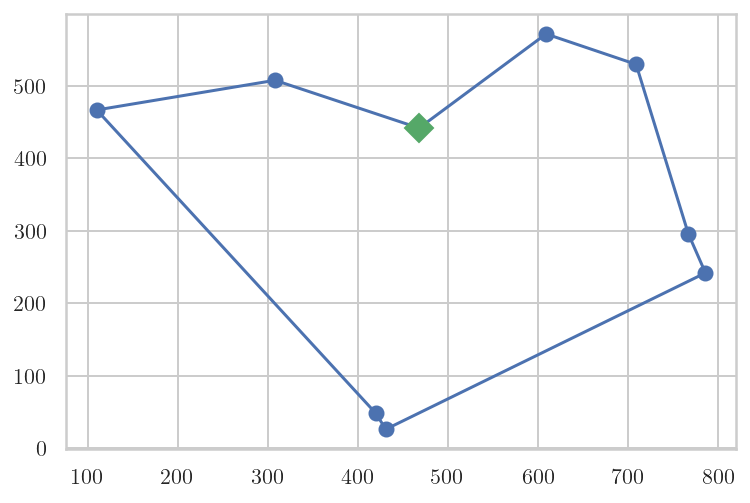

In [24]:
plot_tour(exact_non_redundant_TSP(cities))

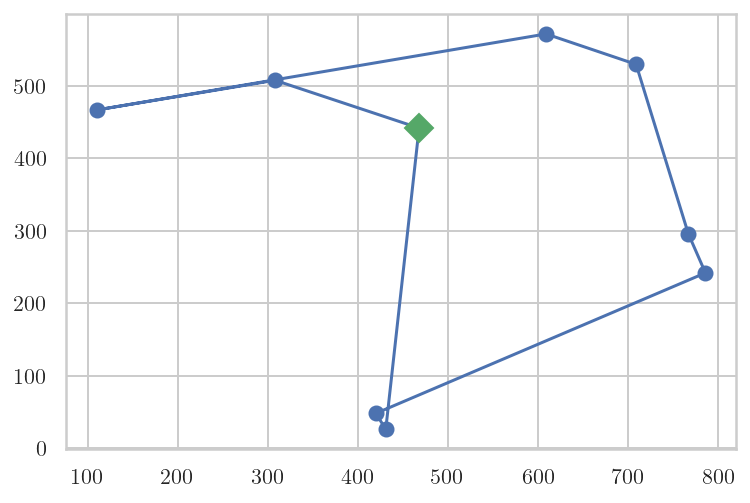

In [25]:
plot_tour(greedy_TSP(cities))

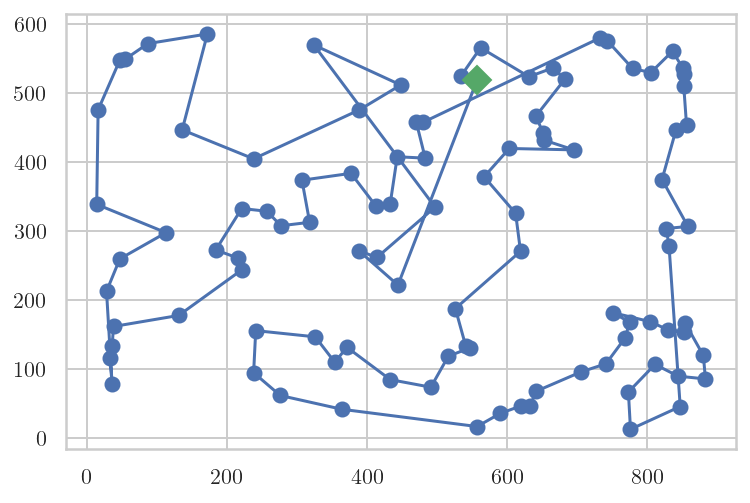

In [26]:
plot_tour(greedy_TSP(cities100))

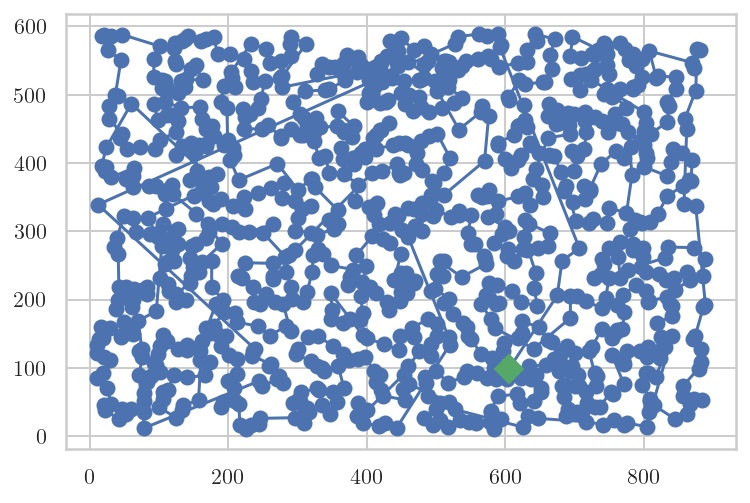

In [27]:
plot_tour(greedy_TSP(cities1000))

##### Tiempos de los algoritmos

In [28]:
%timeit exact_non_redundant_TSP(cities)

203 ms ± 6.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit greedy_TSP(cities)

23.1 µs ± 508 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
%timeit greedy_TSP(cities100)

2.08 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%timeit greedy_TSP(cities1000)

194 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Solución con Algoritmos Genéticos

Las metaheurísticas inspiradas en la naturaleza son una opción en la que dedicamos un poco más de esfuerzo computacional, pero con el fin de producir mejores soluciones que la opción avariciosa.

> Usaremos la biblioteca [DEAP](https://github.com/DEAP/deap) para codificar este problema con un algoritmo genético.
[<img src='https://raw.githubusercontent.com/DEAP/deap/master/doc/_static/deap_long.png' width='29%' align='center'/>](https://github.com/DEAP/deap)

#### ¿Por qué DEAP?
- Las estructuras de datos son clave para la computación evolutiva, deben facilitar la implementación de algoritmos y ser sencillas de adaptar a un problema propio.
- El operador de selección y los parámetros del algoritmo tienen fuertes influencias en las evoluciones, mientras que dependen habitualmente del problema. Es importante que se pueda parametrizar todo aspecto del algoritmo con la complejidad mínima.
- Los algoritmos evolutivos cuestan de paralelizar, por tanto los mecanismos que implementan paradigmas de distribución deben ser triviales de utilizar. Por eso se proporciona su proyecto hermano, **SCOOP**.


In [32]:
from deap import algorithms, base, creator, tools

Generamos, por ejemplo, 30 ciudades.

In [33]:
num_cities = 30
cities = generate_cities(num_cities)

Creamos un módulo **toolbox** con el fin de agrupar todos los operadores en una sola estructura, crear un alias para los operadores y registrar los parámetros de los operadores.

In [34]:
toolbox = base.Toolbox()

Agrupamos las clases en un único módulo con **creator** por herencia.

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

Registramos las principales operaciones de nuestro problema.

In [38]:
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

toolbox.register("evaluate", evaluation)

toolbox.register("select", tools.selTournament, tournsize=3)

La función de evaluación se basará en la distancia total (fitness).

In [37]:
def create_tour(individual):
    return [list(cities)[e] for e in individual]

def evaluation(individual):
    '''Evaluates an individual by converting it into 
    a list of cities and passing that list to total_distance'''
    return (total_distance(create_tour(individual)),)

In [44]:
pop = toolbox.population(n=100)

##### Ejecución del algoritmo con 100 individuos y 400 generaciones, probabilidad de mutación 20% y de cruce 80%

In [68]:
%%time
result1, log1 = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.2, ngen=400, verbose=False)

CPU times: user 8.78 s, sys: 134 ms, total: 8.91 s
Wall time: 9.5 s


In [67]:
%%time
for i in range (0, 400, 5):
    result, log = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.2, ngen=400, verbose=False)

CPU times: user 9min 24s, sys: 4.75 s, total: 9min 29s
Wall time: 9min 51s


In [69]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  3413.272467947316


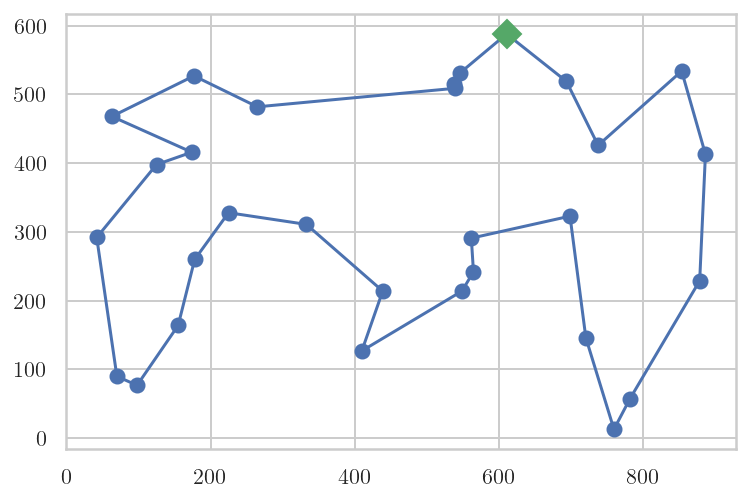

In [47]:
plot_tour(create_tour(best_individual))

In [48]:
print('greedy_TSP() distance: ', total_distance(greedy_TSP(cities)))
print('Genetic algorithm best distance: ', evaluation(best_individual)[0])

greedy_TSP() distance:  3954.2844199539823
Genetic algorithm best distance:  3417.04255782294


### Paralelización del GA con SCOOP

`SCOOP` no se puede ejecutar en Notebook, así que esta sección se encuentra en `tsp_scoop.py`.
La idea es utilizar una operación de mapeo que aplica una función a cada elemento de una secuencia. En concreto, para evaluar el fitness. Por defecto, cada toolbox está registrada con la función estándar `map`. Para que los algoritmos evalúen a los individuos sólo hay que reemplazar el alias *map* por un map paralelo como el proporcionado por `SCOOP`. Los resultados se añaden en las slides del proyecto.

### ¿Y por qué no probamos con MPI?

Los métodos anteriores basados en GA tienen limitaciones cuando se prueban programas paralelos MPI con bloqueo de comunicación. Los resultados se ofrecen en las slides del proyecto, mientras que el código se encuentra en `tsp_mpi.py` 